# Using machine learning methods to recognize the elpv dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Copy images and labels data.
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/images ./images/
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/labels.csv ./

## Explore data preprocessing results

<IPython.core.display.Javascript object>

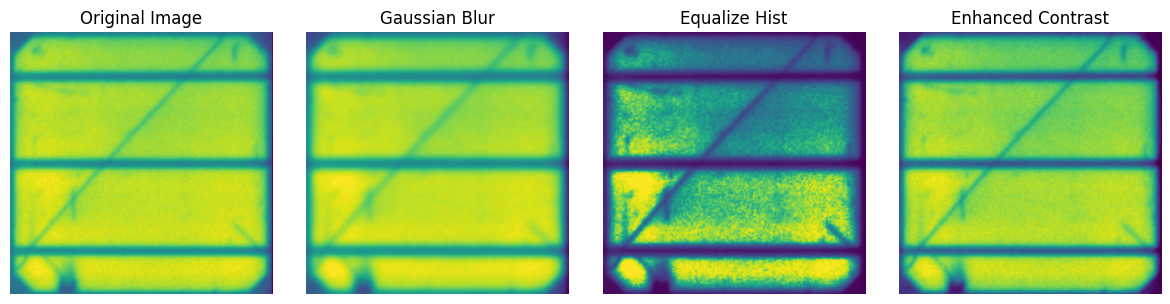

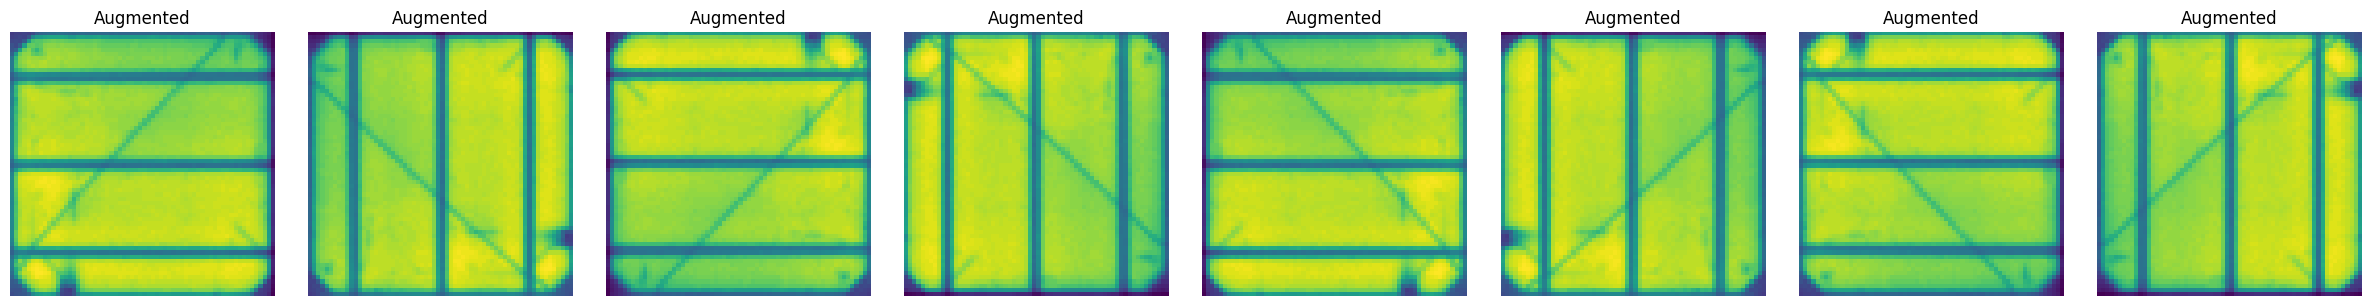

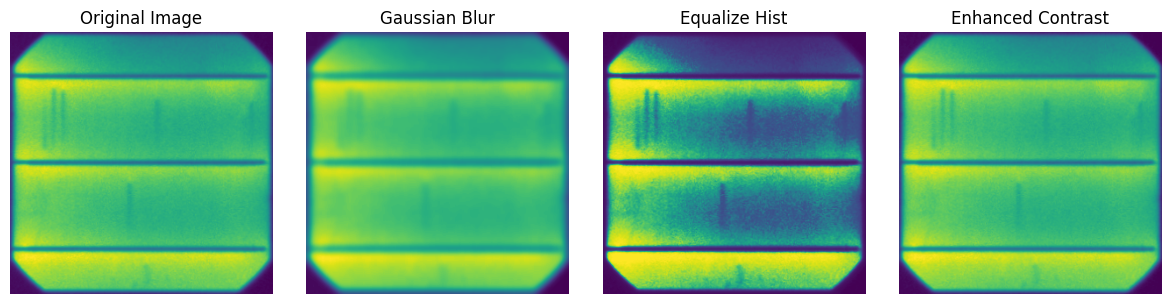

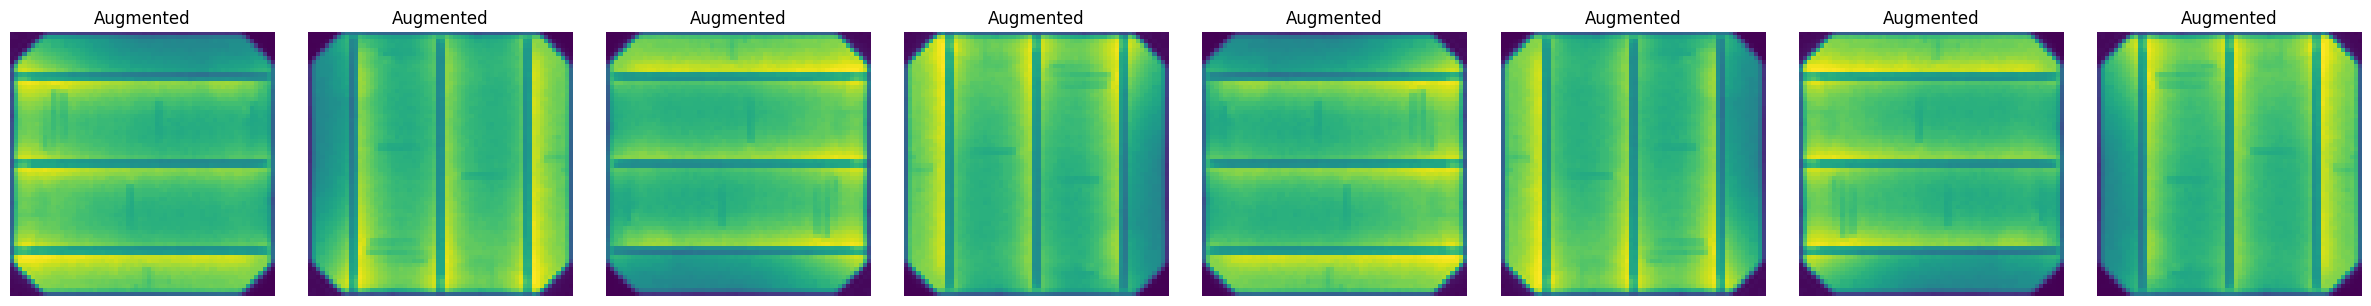

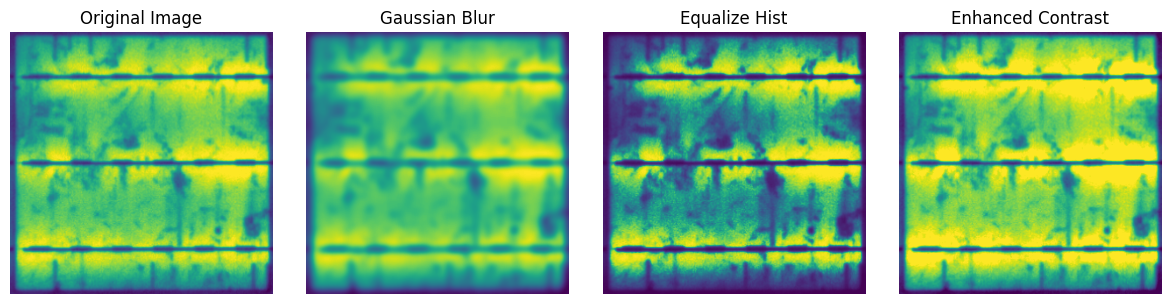

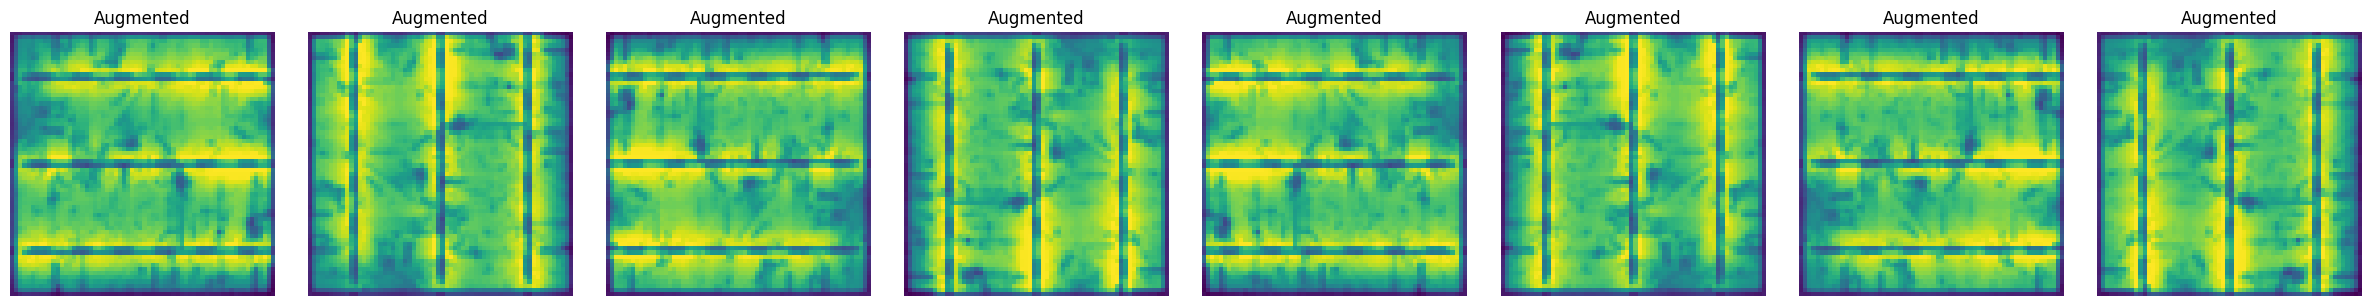

In [ ]:
from IPython.display import Javascript

# Remove the height limit of the Colab output area
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))
remove_output_scrolling()



# Display image grid.
def display_image_grid(images, titles, cols, filename):
    rows = (len(images) + cols - 1) // cols  # Calculate the required number of rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{filename}.png")
    plt.show()

# Data augmentation function generates rotated and flipped images.
def augment_image(image, new_size):
    # resize image
    image = image.resize(new_size, Image.LANCZOS)
    # Generate rotated and flipped images.
    rotations = [0, 90, 180, 270]
    augmented_images = [image.rotate(angle) for angle in rotations]
    augmented_images += [ImageOps.mirror(img) for img in augmented_images]
    return augmented_images


# Load data, apply preprocessing, display preprocessing and augmentation results.
def preprocess_and_display_images(fname, new_size=(64, 64), augment=False):
    # Read image paths.
    data = np.genfromtxt(fname, dtype=[('path', 'U19')], delimiter=',', skip_header=1)
    image_fnames = data['path']

    # Process the first two images.
    for i, fn in enumerate(image_fnames):
        if (i==1 or i==1000 or i==2000):
          img = Image.open(fn)
          processed_images = [img]  # Save the original and preprocessed images
          titles = ['Original Image']

          img_blurred = img.filter(ImageFilter.GaussianBlur(radius=3))
          processed_images.append(img_blurred)
          titles.append('Gaussian Blur')

          img_equalized = ImageOps.equalize(img)
          processed_images.append(img_equalized)
          titles.append('Equalize Hist')

          enhancer = ImageEnhance.Contrast(img)
          img_enhanced = enhancer.enhance(1.5)
          processed_images.append(img_enhanced)
          titles.append('Enhanced Contrast')

          # Display preprocessing results
          display_image_grid(processed_images, titles, 4, f"preprocessed_{i}")

          # If data augmentation is enabled, display augmentation results
          if augment:
              augmented_images = augment_image(img, new_size)
              augmented_titles = ['Augmented'] * len(augmented_images)
              display_image_grid(augmented_images, augmented_titles, 8, f"augmented_{i}")

# Invoke the function
preprocess_and_display_images('labels.csv', augment=True)


## Data loading, preprocessing, and data augmentation

###  Define data preprocessing and data augmentation functions.

In [ ]:
# Data preprocessing
def preprocess_image(image, GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False):

    # image_resize
    if image_resize:
      image = image.resize(new_size, Image.LANCZOS)

    # Image denoising
    if GaussianBlur:
      image = image.filter(ImageFilter.GaussianBlur(radius=3))

    # Histogram equalization
    if equalize_hist:
        image = ImageOps.equalize(image)

    # Contrast enhancement
    if enhance_contrast:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.5)

    return image


# Data augmentation: Rotation and flipping
def augment_image(image, new_size):
    # resize image
    image = image.resize(new_size, Image.LANCZOS)
    rotations = [0, 90, 180, 270]
    flipped_image = ImageOps.mirror(image)  # Horizontal flipping
    rotated_images = [image.rotate(angle) for angle in rotations]
    rotated_flipped_images = [flipped_image.rotate(angle) for angle in rotations]
    return rotated_images + rotated_flipped_images



# Data loading function with preprocessing and image augmentation
def load_dataset(fname='labels.csv',GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False, augment=False):
    data = np.genfromtxt(fname, dtype=[ \
      ('path', np.string_, 19), \
      ('probability', np.float64), \
      ('type', np.string_, 4)], \
      names=['path', 'probability', 'type'])

    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    dir = os.path.dirname(fname)
    images = []
    for fn in image_fnames:
        with Image.open(os.path.join(dir, fn)) as img:
            # Preprocess images
            processed_img = preprocess_image(img,GaussianBlur,image_resize,new_size,enhance_contrast,equalize_hist)
            images.append(np.asarray(processed_img))
            # If data augmentation is enabled
            if augment:
                augmented_imgs = augment_image(processed_img, new_size)
                images.extend(np.asarray(img) for img in augmented_imgs)

    # Normalize all images
    images = np.array(images).astype('float32') / 255.0

    # If data augmentation was performed, adjust probability and label types accordingly
    if augment:
        probs = np.repeat(probs, 9)  # 1 original + 4 rotated + 4 rotated after flipping
        types = np.repeat(types, 9)

    return images, probs, types


# 加载数据
images, probabilities, types = load_dataset(augment=False)

### Load the data

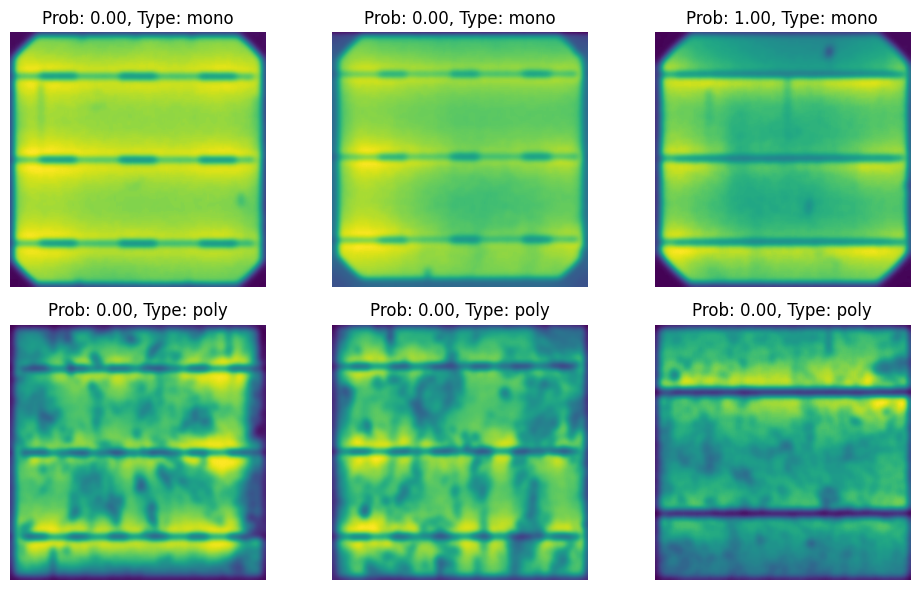

In [ ]:
# Formally load the data
images, probabilities, types = load_dataset(GaussianBlur=True, \
                        image_resize=False, new_size=(64, 64), \
                        enhance_contrast=False, \
                        equalize_hist=False,\
                        augment=False)


# Randomly display data
def display_random_images_with_titles(images, probabilities=None, types=None, n_rows=2, n_cols=3):
    """
    Displays a grid of randomly selected images from a given ndarray of image arrays with titles.
    If probabilities or types are None, no titles will be displayed.

    Parameters:
    - images: An ndarray where each item is an image array.
    - probabilities: An optional ndarray of probabilities associated with each image.
    - types: An optional ndarray of types associated with each image.
    - n_rows: Number of rows in the subplot grid.
    - n_cols: Number of columns in the subplot grid.
    """
    # Number of images to display
    num_images = n_rows * n_cols

    # Ensure the array has the right number of dimensions
    assert images.ndim == 3, "Input images array must be 3-dimensional"

    # Ensure there are enough images to display
    assert images.shape[0] >= num_images, "Not enough images to display. Required: {}, Available: {}".format(num_images, images.shape[0])

    # Randomly select indices for images
    selected_indices = np.random.choice(images.shape[0], size=num_images, replace=False)

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))

    # Flatten the axes array for easy iteration if necessary
    axes_flat = axes.flat if n_rows * n_cols > 1 else [axes]

    # Check if probabilities and types are provided
    show_titles = probabilities is not None and types is not None

    # Iterate over the selected images and the subplot axes
    for ax, idx in zip(axes_flat, selected_indices):
        # Display the image
        ax.imshow(images[idx])
        if show_titles:
            # If probabilities and types are provided, display them as titles
            ax.set_title(f'Prob: {probabilities[idx]:.2f}, Type: {types[idx]}')
        ax.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

display_random_images_with_titles(images, probabilities, types, n_rows=2, n_cols=3)

### Split the dataset

In [ ]:
# Flatten image data into one-dimensional vectors
images_flatten = np.array([img.flatten() for img in images])

# Label encoding
le_prob = LabelEncoder()
labels_prob = le_prob.fit_transform(probabilities)

# Separate 'poly' and 'mono' features and labels
features_poly = images_flatten[types == 'poly']
labels_prob_poly = labels_prob[types == 'poly']

features_mono = images_flatten[types == 'mono']
labels_prob_mono = labels_prob[types == 'mono']

# Use train_test_split to split 'poly' and 'mono' data separately
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(features_poly, labels_prob_poly, test_size=0.25, random_state=15)

X_train_mono, X_test_mono, y_train_mono, y_test_mono = train_test_split(features_mono, labels_prob_mono, test_size=0.25, random_state=15)

### PCA dimensionality reduction

In [ ]:
# PCA dimensionality reduction
pca_poly = PCA(n_components=0.95)
X_train_poly_pca = pca_poly.fit_transform(X_train_poly)
X_test_poly_pca = pca_poly.transform(X_test_poly)

pca_mono = PCA(n_components=0.95)
X_train_mono_pca = pca_mono.fit_transform(X_train_mono)
X_test_mono_pca = pca_mono.transform(X_test_mono)

print(pca_poly.n_components_)
print(pca_mono.n_components_)

53
13


## 6. Train and predict on the data

In [ ]:
# Initialize variables to record scores for each iteration and the best score
best_accuracy_poly_svm, total_accuracy_poly_svm = 0, 0
best_f1_score_poly_svm, total_f1_score_poly_svm = 0, 0
best_accuracy_poly_rf, total_accuracy_poly_rf = 0, 0
best_f1_score_poly_rf, total_f1_score_poly_rf = 0, 0
best_accuracy_mono_svm, total_accuracy_mono_svm = 0, 0
best_f1_score_mono_svm, total_f1_score_mono_svm = 0, 0
best_accuracy_mono_rf, total_accuracy_mono_rf = 0, 0
best_f1_score_mono_rf, total_f1_score_mono_rf = 0, 0

svm_predictions_poly = None
svm_predictions_mono = None
rf_predictions_poly = None
rf_predictions_mono = None

num_iterations = 30

for i in range(num_iterations):
    # Train and predict - Poly data
    svm_poly = SVC(kernel='rbf', gamma='scale')
    rf_poly = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    svm_poly.fit(X_train_poly_pca, y_train_poly)
    rf_poly.fit(X_train_poly_pca, y_train_poly)
    predictions_poly_svm = svm_poly.predict(X_test_poly_pca)
    predictions_poly_rf = rf_poly.predict(X_test_poly_pca)

    # Train and predict - Mono data
    svm_mono = SVC(kernel='rbf', gamma='scale')
    rf_mono = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    svm_mono.fit(X_train_mono_pca, y_train_mono)
    rf_mono.fit(X_train_mono_pca, y_train_mono)
    predictions_mono_svm = svm_mono.predict(X_test_mono_pca)
    predictions_mono_rf = rf_mono.predict(X_test_mono_pca)

    svm_predictions_poly = predictions_poly_svm
    svm_predictions_mono = predictions_mono_svm
    rf_predictions_poly = predictions_poly_rf
    rf_predictions_mono = predictions_mono_rf

    # Update and record scores - Poly data
    current_accuracy_poly_svm = accuracy_score(y_test_poly, predictions_poly_svm)
    current_f1_score_poly_svm = f1_score(y_test_poly, predictions_poly_svm, average='weighted')
    total_accuracy_poly_svm += current_accuracy_poly_svm
    total_f1_score_poly_svm += current_f1_score_poly_svm
    if current_accuracy_poly_svm > best_accuracy_poly_svm:
        best_accuracy_poly_svm = current_accuracy_poly_svm
        best_f1_score_poly_svm = current_f1_score_poly_svm

    current_accuracy_poly_rf = accuracy_score(y_test_poly, predictions_poly_rf)
    current_f1_score_poly_rf = f1_score(y_test_poly, predictions_poly_rf, average='weighted')
    total_accuracy_poly_rf += current_accuracy_poly_rf
    total_f1_score_poly_rf += current_f1_score_poly_rf
    if current_accuracy_poly_rf > best_accuracy_poly_rf:
        best_accuracy_poly_rf = current_accuracy_poly_rf
        best_f1_score_poly_rf = current_f1_score_poly_rf


    # Update and record scores - Mono data
    current_accuracy_mono_svm = accuracy_score(y_test_mono, predictions_mono_svm)
    current_f1_score_mono_svm = f1_score(y_test_mono, predictions_mono_svm, average='weighted')
    total_accuracy_mono_svm += current_accuracy_mono_svm
    total_f1_score_mono_svm += current_f1_score_mono_svm
    if current_accuracy_mono_svm > best_accuracy_mono_svm:
        best_accuracy_mono_svm = current_accuracy_mono_svm
        best_f1_score_mono_svm = current_f1_score_mono_svm

    current_accuracy_mono_rf = accuracy_score(y_test_mono, predictions_mono_rf)
    current_f1_score_mono_rf = f1_score(y_test_mono, predictions_mono_rf, average='weighted')
    total_accuracy_mono_rf += current_accuracy_mono_rf
    total_f1_score_mono_rf += current_f1_score_mono_rf
    if current_accuracy_mono_rf > best_accuracy_mono_rf:
        best_accuracy_mono_rf = current_accuracy_mono_rf
        best_f1_score_mono_rf = current_f1_score_mono_rf


## 7. Display prediction results

<IPython.core.display.Javascript object>

Average and Best Results:
Poly SVM - Avg Accuracy: 0.6984536082474228, Best Accuracy: 0.6984536082474226, Avg F1 Score: 0.6501740788951128, Best F1 Score: 0.6501740788951131
Poly RF - Avg Accuracy: 0.7426116838487974, Best Accuracy: 0.7654639175257731, Avg F1 Score: 0.709164657398209, Best F1 Score: 0.7351539061641003
Mono SVM - Avg Accuracy: 0.7323420074349443, Best Accuracy: 0.7323420074349443, Avg F1 Score: 0.6727385377942998, Best F1 Score: 0.6727385377942998
Mono RF - Avg Accuracy: 0.7413878562577448, Best Accuracy: 0.758364312267658, Avg F1 Score: 0.7185467206647144, Best F1 Score: 0.7368034098003051


<Figure size 5000x3000 with 0 Axes>

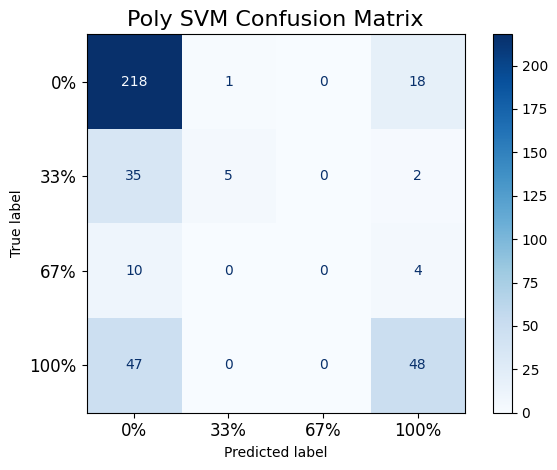

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.70      0.92      0.80       237
         33%       0.83      0.12      0.21        42
         67%       0.00      0.00      0.00        14
        100%       0.67      0.51      0.57        95

    accuracy                           0.70       388
   macro avg       0.55      0.39      0.40       388
weighted avg       0.68      0.70      0.65       388



<Figure size 5000x3000 with 0 Axes>

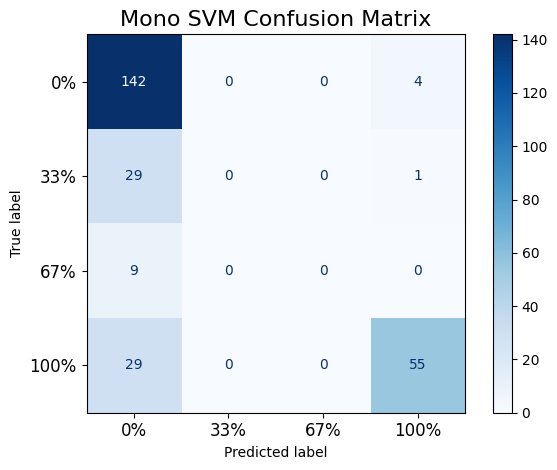

Mono SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.68      0.97      0.80       146
         33%       0.00      0.00      0.00        30
         67%       0.00      0.00      0.00         9
        100%       0.92      0.65      0.76        84

    accuracy                           0.73       269
   macro avg       0.40      0.41      0.39       269
weighted avg       0.66      0.73      0.67       269



<Figure size 5000x3000 with 0 Axes>

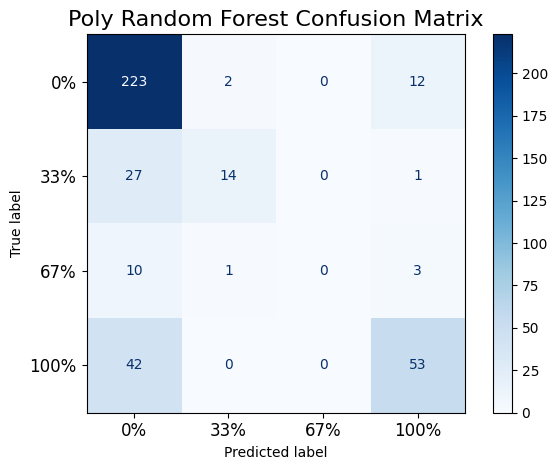

Poly Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.74      0.94      0.83       237
         33%       0.82      0.33      0.47        42
         67%       0.00      0.00      0.00        14
        100%       0.77      0.56      0.65        95

    accuracy                           0.75       388
   macro avg       0.58      0.46      0.49       388
weighted avg       0.73      0.75      0.72       388



<Figure size 5000x3000 with 0 Axes>

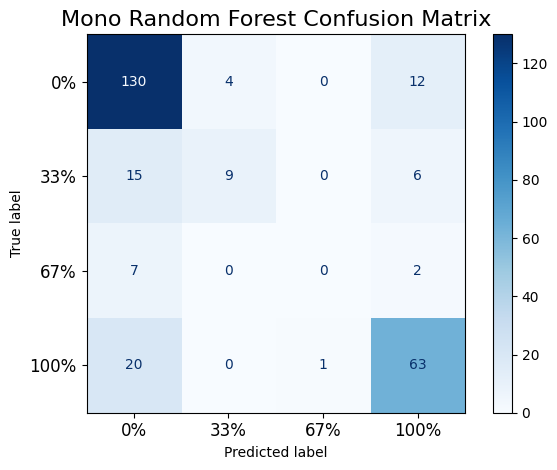

Mono Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.76      0.89      0.82       146
         33%       0.69      0.30      0.42        30
         67%       0.00      0.00      0.00         9
        100%       0.76      0.75      0.75        84

    accuracy                           0.75       269
   macro avg       0.55      0.49      0.50       269
weighted avg       0.72      0.75      0.73       269



In [ ]:
from IPython.display import Javascript

# Remove Colab output area height limit
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))
remove_output_scrolling()



# Calculate average accuracy and F1 score
average_accuracy_poly_svm = total_accuracy_poly_svm / num_iterations
average_f1_score_poly_svm = total_f1_score_poly_svm / num_iterations
average_accuracy_poly_rf = total_accuracy_poly_rf / num_iterations
average_f1_score_poly_rf = total_f1_score_poly_rf / num_iterations
average_accuracy_mono_svm = total_accuracy_mono_svm / num_iterations
average_f1_score_mono_svm = total_f1_score_mono_svm / num_iterations
average_accuracy_mono_rf = total_accuracy_mono_rf / num_iterations
average_f1_score_mono_rf = total_f1_score_mono_rf / num_iterations

# Print average results and best results
print("Average and Best Results:")
print(f"Poly SVM - Avg Accuracy: {average_accuracy_poly_svm}, Best Accuracy: {best_accuracy_poly_svm}, Avg F1 Score: {average_f1_score_poly_svm}, Best F1 Score: {best_f1_score_poly_svm}")
print(f"Poly RF - Avg Accuracy: {average_accuracy_poly_rf}, Best Accuracy: {best_accuracy_poly_rf}, Avg F1 Score: {average_f1_score_poly_rf}, Best F1 Score: {best_f1_score_poly_rf}")
print(f"Mono SVM - Avg Accuracy: {average_accuracy_mono_svm}, Best Accuracy: {best_accuracy_mono_svm}, Avg F1 Score: {average_f1_score_mono_svm}, Best F1 Score: {best_f1_score_mono_svm}")
print(f"Mono RF - Avg Accuracy: {average_accuracy_mono_rf}, Best Accuracy: {best_accuracy_mono_rf}, Avg F1 Score: {average_f1_score_mono_rf}, Best F1 Score: {best_f1_score_mono_rf}")



# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(50, 30), fontsize=12):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title, fontsize=fontsize+4)

    # Increase the font size of the x and y-axis
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

# Compute the confusion matrix
svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)

rf_cm_poly = confusion_matrix(y_test_poly, rf_predictions_poly)
rf_cm_mono = confusion_matrix(y_test_mono, rf_predictions_mono)

label_mapping = {
    0: '0%',
    1: '33%',
    2: '67%',
    3: '100%'
}

# Plot the confusion matrix and print the classification report
plot_confusion_matrix(svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly SVM Classification Report:\n", svm_report_poly)
plot_confusion_matrix(svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono SVM Classification Report:\n", svm_report_mono)


plot_confusion_matrix(rf_cm_poly, classes=list(label_mapping.values()), title='Poly Random Forest Confusion Matrix')
rf_report_poly = classification_report(y_test_poly, rf_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly Random Forest Classification Report:\n", rf_report_poly)
plot_confusion_matrix(rf_cm_mono, classes=list(label_mapping.values()), title='Mono Random Forest Confusion Matrix')
rf_report_mono = classification_report(y_test_mono, rf_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono Random Forest Classification Report:\n", rf_report_mono)



## Attempt to use a hybrid model of Random Forest + SVM

<IPython.core.display.Javascript object>

Poly SVM - Avg Accuracy: 0.7415807560137456, Best Accuracy: 0.7654639175257731, Avg F1 Score: 0.7216009787145875, Best F1 Score: 0.7454285334181752
Mono SVM - Avg Accuracy: 0.7402726146220571, Best Accuracy: 0.7620817843866171, Avg F1 Score: 0.723360029215557, Best F1 Score: 0.7479024292625536


<Figure size 5000x3000 with 0 Axes>

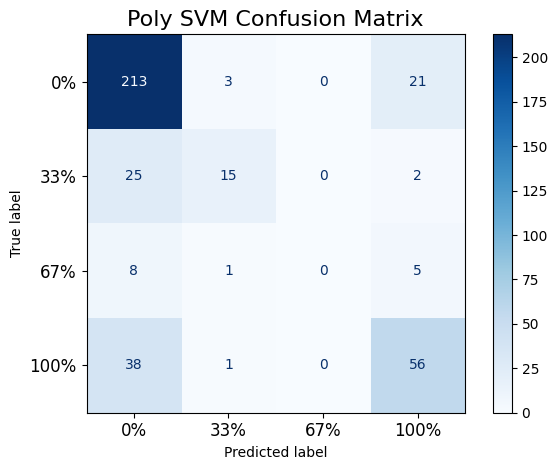

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.75      0.90      0.82       237
         33%       0.75      0.36      0.48        42
         67%       0.00      0.00      0.00        14
        100%       0.67      0.59      0.63        95

    accuracy                           0.73       388
   macro avg       0.54      0.46      0.48       388
weighted avg       0.70      0.73      0.71       388



<Figure size 5000x3000 with 0 Axes>

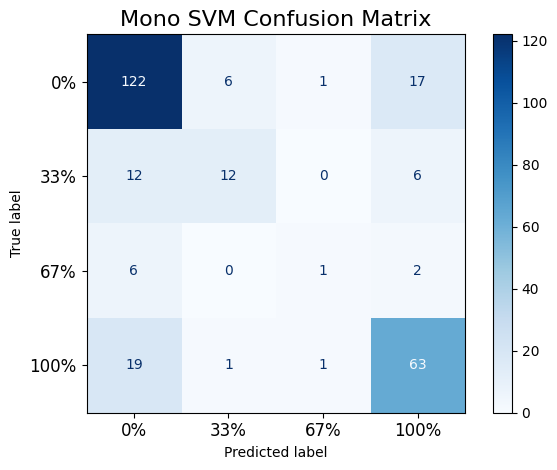

Mono SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.77      0.84      0.80       146
         33%       0.63      0.40      0.49        30
         67%       0.33      0.11      0.17         9
        100%       0.72      0.75      0.73        84

    accuracy                           0.74       269
   macro avg       0.61      0.52      0.55       269
weighted avg       0.72      0.74      0.72       269



In [ ]:
from IPython.display import Javascript

# Remove Colab output area height limit
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))
remove_output_scrolling()


# Initialize variables to record scores for each iteration and the best score
best_accuracy_poly_svm, total_accuracy_poly_svm = 0, 0
best_f1_score_poly_svm, total_f1_score_poly_svm = 0, 0
best_accuracy_mono_svm, total_accuracy_mono_svm = 0, 0
best_f1_score_mono_svm, total_f1_score_mono_svm = 0, 0


# Variables for saving the results of the last iteration
last_svm_cm_poly, last_svm_cm_mono = None, None
last_svm_report_poly, last_svm_report_mono = None, None

for i in range(num_iterations):
    # Train the Random Forest model
    rf_poly = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf_poly.fit(X_train_poly_pca, y_train_poly)
    rf_mono = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf_mono.fit(X_train_mono_pca, y_train_mono)

    # Generate a new feature set using the Random Forest model
    X_train_poly_rf = rf_poly.predict_proba(X_train_poly_pca)
    X_test_poly_rf = rf_poly.predict_proba(X_test_poly_pca)
    X_train_mono_rf = rf_mono.predict_proba(X_train_mono_pca)
    X_test_mono_rf = rf_mono.predict_proba(X_test_mono_pca)

    # Train the SVM model
    svm_poly = SVC(kernel='rbf', gamma='scale', probability=True)
    svm_poly.fit(X_train_poly_rf, y_train_poly)
    svm_mono = SVC(kernel='rbf', gamma='scale', probability=True)
    svm_mono.fit(X_train_mono_rf, y_train_mono)

    # Make predictions
    svm_predictions_poly = svm_poly.predict(X_test_poly_rf)
    svm_predictions_mono = svm_mono.predict(X_test_mono_rf)

    # Calculate accuracy and F1 score
    current_accuracy_poly_svm = accuracy_score(y_test_poly, svm_predictions_poly)
    current_f1_score_poly_svm = f1_score(y_test_poly, svm_predictions_poly, average='weighted')
    total_accuracy_poly_svm += current_accuracy_poly_svm
    total_f1_score_poly_svm += current_f1_score_poly_svm
    if current_accuracy_poly_svm > best_accuracy_poly_svm:
        best_accuracy_poly_svm = current_accuracy_poly_svm
        best_f1_score_poly_svm = current_f1_score_poly_svm

    current_accuracy_mono_svm = accuracy_score(y_test_mono, svm_predictions_mono)
    current_f1_score_mono_svm = f1_score(y_test_mono, svm_predictions_mono, average='weighted')
    total_accuracy_mono_svm += current_accuracy_mono_svm
    total_f1_score_mono_svm += current_f1_score_mono_svm
    if current_accuracy_mono_svm > best_accuracy_mono_svm:
        best_accuracy_mono_svm = current_accuracy_mono_svm
        best_f1_score_mono_svm = current_f1_score_mono_svm

    # Record the results of the last iteration
    if i == num_iterations - 1:
        last_svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
        last_svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
        last_svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)
        last_svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)

# Calculate average accuracy and F1 score
average_accuracy_poly_svm = total_accuracy_poly_svm / num_iterations
average_f1_score_poly_svm = total_f1_score_poly_svm / num_iterations
average_accuracy_mono_svm = total_accuracy_mono_svm / num_iterations
average_f1_score_mono_svm = total_f1_score_mono_svm / num_iterations

# Print average and best results
print(f"Poly SVM - Avg Accuracy: {average_accuracy_poly_svm}, Best Accuracy: {best_accuracy_poly_svm}, Avg F1 Score: {average_f1_score_poly_svm}, Best F1 Score: {best_f1_score_poly_svm}")
print(f"Mono SVM - Avg Accuracy: {average_accuracy_mono_svm}, Best Accuracy: {best_accuracy_mono_svm}, Avg F1 Score: {average_f1_score_mono_svm}, Best F1 Score: {best_f1_score_mono_svm}")

# Display the confusion matrix and classification report for the last iteration
plot_confusion_matrix(last_svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
print("Poly SVM Classification Report:\n", last_svm_report_poly)
plot_confusion_matrix(last_svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
print("Mono SVM Classification Report:\n", last_svm_report_mono)